# U N I V E R S I T Y         O F              C A P E T O W N

# Department of Electrical Engineering

<img src = 'Picture1.jpg' width =200>

EEE4114F: **Digital Signals Processing**

Machine Learning Project: **Classification of Hand-Drawn Shapes**

VLLAZR002 – AZRAA VALLY

WLDBIL001 – BILAL WALEED

21 June 2021

***

## Introduction

Being able to classify hand-drawn images and handwriting is an important task with multiple applications. These can range from applications which solve handwritten maths equations to possibly creating applications to convert hand drawn circuits into digital models on programmes such as LTSpice. The emergence of Convolutional Neural Networks (CNNs) has driven the development of this field as it is a powerful framework for feature recognition and representation and image analysis. 

In this task, we will explore the use of a simple CNN architecture, the Lenet-5, to try and classify hand-sketched shapes, with the aim of achieving an accuracy >95%. We will also create a Graphical User Interface (GUI) to allow users to draw a shape which can then be submitted for classification. Alternatively, the user will be able to upload an image of a hand-drawn shape to be classified. 

We will initially be limiting our model to learn and classify five different shapes, which is then expanded to eight shapes. These will be the circle, the diamond, the square, the star, and the triangle. The data used to train, validate and test the model is obtained through Google’s 	[Quickdraw]( https://quickdraw.withgoogle.com/data) dataset of drawings from over 15 million users. Examples of these drawings are shown below. 
<img src = 'Shapes.png' width = 300>

We will make use of the *PyTorch* machine learning framework to train and apply the model, while *Tk GUI Toolkit* will be used to create the GUI.

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import SubsetRandomSampler
from PIL import Image

## Data
As mentioned, the data used to train, validate and test, is obtained from Google's Quickdraw. This data is provided as `.npy` files.

Each image is of size 28x28, but has been flattened into a 1D vector. This will need to be adjusted so that the 2D structure can be prepared before entering the CNN. The respective sizes of each dataset is shown below, with the 784 pixels of each image indicative of the flattening of the original 28x28 image.  


In [2]:
#load training data 
circle = np.load(Path.cwd() / "datasets" / "circle.npy")
diamond = np.load(Path.cwd() / "datasets" / "diamond.npy")
square = np.load(Path.cwd() / "datasets" / "square.npy")
star = np.load(Path.cwd() / "datasets" / "star.npy")
triangle = np.load(Path.cwd() / "datasets" / "triangle.npy")
# print number of images in dataset and numpy array size of each image
print("          no_of_pics, pixels_size")
print("Circle:  ", format(circle.shape))
print("Diamond: ", diamond.shape)
print("Square:  ", square.shape)
print("Star:    ", star.shape)
print("Triangle:", triangle.shape)

          no_of_pics, pixels_size
Circle:   (122876, 784)
Diamond:  (131587, 784)
Square:   (125145, 784)
Star:     (137619, 784)
Triangle: (123170, 784)


### Data Preparation
The data needs to be prepared in various manners before it is ready to be loaded into the model. 

***
1. Labelling - For this step, the method of Integer Labelling has been used. This involves adding a column to each dataset with a label associating it with its true shape. 


In [3]:
#libraries like Pytorch don't bother with needing to do one-hot encoding explicitly, and instead usually 
#work with labels provided as "indices".
#this can be done by adding a column with labels, 0=circle, 1=diamond, 2=sqaure, 3=star, 4=triangle 
circle = np.c_[circle, np.zeros(len(circle))]
diamond = np.c_[diamond, np.ones(len(diamond))]
square = np.c_[square, 2*np.ones(len(square))]
star = np.c_[star, 3*np.ones(len(star))]
triangle = np.c_[triangle, 4*np.ones(len(triangle))]


2. Combining - The individual datasets are then combined into two datasets; one for the images ( *x_set*) and one for the integer labels  (*y_set*). It should be noted that only the first 5000 images of each set is used to reduce the overall size of the data and therefore training time. This can be increased to improve the model performance if necessary.


3. Splitting - The data is then split using the *Three-Way Holdout Method*
  > This method involves splitting the data twice. The first split creates data used for learning and data used for testing. The second split divides the data into data used for training the model, and for validating the model. The test data is only applied when the model validation performance is found to be satisfactory. This data is therefore considered to be unseen data to the model and provides a way to ensure that your model can be applied on data it has not been trained with. <br><br> The advantage of this is that it eliminates an issue that is coined information leak. This occurs when, due to random sampling of data, you end up testing your model on data that it was also trained on, causing the results to be overly optimistic.<br><br> We have employed a split where 30% of the data is split away as test data, while 10% of the remaining data is used as validation. All other data (63%), is used for testing.

In [4]:
#create training datasets 
x_train = np.concatenate((circle[:10000,:-1], diamond[:10000,:-1], square[:10000,:-1], star[:10000,:-1], triangle[:10000,:-1]), axis=0).astype('float32')# all columns but the last
y_train = np.concatenate((circle[:10000,-1], diamond[:10000,-1], square[:10000,-1], star[:10000,-1], triangle[:10000,-1]), axis=0) # the last column

x_learn, x_test, y_learn, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_learn, y_learn, test_size=0.5, random_state=1)

4. Reshaping - Reshaping is done so the data is in the form of a 2D image which can be prepared before entering the neural network.


5. Scaling and Transforming - All data needs to be transformed to ensure that all parameters exist on the same scale, such that they have equal weighting when the model is being trained. Here we are first removing the mean of the data, dividing the result by its standard deviation, and then scaling the data to exist between 0 and 1.

In [5]:
x_train_cnn = x_train.reshape(x_train.shape[0], 28, 28)
#print(x_train_cnn.shape)
#print(x_train_cnn)
x_val_cnn = x_val.reshape(x_val.shape[0], 28, 28)
x_test_cnn = x_test.reshape(x_test.shape[0], 28, 28)

scaler = MinMaxScaler((0,1))
x_train_cnn_shape = x_train_cnn.shape
x_val_cnn_shape = x_val_cnn.shape
x_test_cnn_shape = x_test_cnn.shape

# fit scaler on training data, and transform it as well
x_train_cnn = scaler.fit_transform(x_train_cnn.reshape(-1, 1))
x_train_cnn = x_train_cnn.reshape(x_train_cnn_shape)

# only transform sets used for evaluation 
x_val_cnn = scaler.transform(x_val_cnn.reshape(-1, 1))
x_val_cnn = x_val_cnn.reshape(x_val_cnn_shape)

x_test_cnn = scaler.transform(x_test_cnn.reshape(-1, 1))
x_test_cnn = x_test_cnn.reshape(x_test_cnn_shape)
#print(x_train_cnn.shape)
#print(x_train_cnn)

6. Dataloader - A dataloader is created for each dataset (training, validation and test) to easily load the data when required. A custom dataset is also created to help load the data efficiently and perform transformations as needed.

In [6]:
class MSTAR(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.transform = transform
        self.enc = LabelEncoder()
        targets = self.enc.fit_transform(targets.reshape(-1,))
        self.targets = torch.LongTensor(targets)
        
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = int(index.item())
            
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index])
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [7]:
transform = transforms.Compose(
    [
     transforms.ToTensor()
    ])
BATCH_SIZE = 32

# define datasets
train_dataset = MSTAR(x_train_cnn, y_train, transform=transform)
val_dataset = MSTAR(x_val_cnn, y_val, transform=transform)
test_dataset = MSTAR(x_test_cnn, y_test, transform=transform)

BATCH_SIZE=32
# define dataloaders from the datasets(make sure you define a BATCH_SIZE to use)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset)) 

Finally, we can plot some of the data that will be used for to train, validate and test the model.

In [8]:
# function that plots 28x28 pixel drawings
def plot_samples(input_array, rows=1, cols=5, title=''):
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

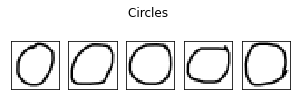

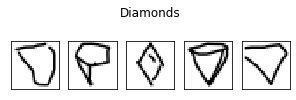

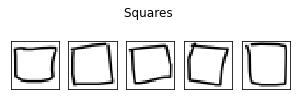

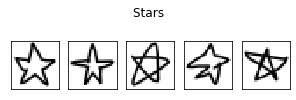

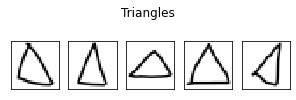

In [9]:
# Plot arm samples
plot_samples(circle, title='Circles \n')
plot_samples(diamond, title = 'Diamonds\n')
plot_samples(square, title = 'Squares \n')
plot_samples(star, title = 'Stars \n')
plot_samples(triangle, title = 'Triangles \n')

# Model Architecture

The model will make use of the Lenet-5 architecture, with variations regarding the size of the kernels and pooling methods used. The complete architecture is shown below and follows the following steps:

1. Convolution - The 28 x 28 input is convolved with 6, 5 x 5 kernels, with a stride of 1. This produces an output of 6 feature maps, each 24 x 24. 
> The output size for a convolution operation with no padding is found as follows:<br>$O = [\frac{W-K}{s}]+1 = [\frac{28-5}{1}]+1 = 24$ 

2. Max Pooling - Each feature maps undergoes max pooling by a 2 x 2 kernel, with stride 2. This produces an output of 6 feature maps, each 12 x 12.
> The output size for a max pooling operation with no padding is found as:<br>$O = [\frac{W - D \times (K-1)-1}{s} + 1] = [\frac{24 - 1 \times (2-1) - 1}{2}] = 12$<br> Note that the square brackets here indicate the floor operation.
3. Convolution - The 6 feature maps are convolved with 16, 5 x 5, kernels, with a stride of 1. This produces an output of 16 feature maps, each 8 x 8.
4. Max Pooling - Each feeature map undergoes max pooling by a 2 x 2 kernel, with stride 2. This produces an output of 16 feature maps, each 4 x 4.
5. Flattening - The 16, 4 x 4, feature maps are then flattened to produce 128 (16 x 4 x 4) input neurons to the neural network.
6. Relu Forward Pass - The input neurons are then passed through the neural network where they are converted to 5 output neurons (with 120 and 84 neurons respectively in the hidden layers)



<img src = 'CNN architecture.jpg' >

***

The *Net()* class implements this architecture by defining the convolutions and max pooling operations. It then implements a forward pass, which refers to the path the input 28 x 28 image takes through the CNN until the 5 output neurons are formed. Note that activation functions are only applied on the outputs of the input layer and the first hidden layer i.e. there is no activation at the final output. 

The activation in use here is the relu function: $\sigma(z) = max(0,z)$. The ease of computation of both it and its gradient make it a popular function.

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # data has a single input channel
        
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        # output is 6, 24x24 feature maps 
        
        self.pool = nn.MaxPool2d(2, 2)  
        #output is 6,  12x12 feature maps 
        
        self.conv2 = nn.Conv2d(6, 16, 5)
        # output is 16, 8x8 feature maps
        
        
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)   

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) #second pooling layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

A new instance of the forward pass operation is created. This model will be trained until satisfactory performance is found. It will then be used to predict the object class of a given 28 x 28 input image.

In [11]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)


### Evaluating and Training

The model needs to now be evaluated and trained. In order to evaluate its performance, we need to be able to calculate the loss of the function as well as its accuracy. While the accuracy is the measure of what percentage of predictions the model gets correct, the loss is measured as a function of the predicted outputs ($\hat{y}$) and the correct outputs ($y$) of each class output. Here, we will make use of the ***Cross-Entropy Loss*** which is calculated as:

$$
J(y, \hat{y}) = -\sum_iP(y_i)log(P(\hat{y}_i))
$$

This method of calculating loss places more emphasis on incorrect classifications, as it is focused more on penalising severly incorrect outputs, as opposed to something like the mean squared error (MSE),which penalises values depending on how far from the correct output it is. This is why the MSE is preferred more for regression tasks.

***

The model needs to be trained in order for the weights to be adjusted to perform. This is essentially where all the learning takes place. The learning method employed is the ***Adam Optimisation Algorithm***, which has been found to be efficient in both time and resource usag It is based, as most optimisation methods are, on the stochastic gradient descent and combines the advantages of other optimisation methods to work well on both probelms that are noist and have sparse gradients.

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

A function is created to evaulate the performance of the model given a dataset. Each image is run with its input values (images) put through the model. THe output values are then compared to the labels to determine the loss. The output that has a max value is then considered to be the predicted value. This is checked against the true value to determine if it is correct. The average loss, and the accuracy ($\frac{\# of correct values}{total values}$) is returned.

In [13]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0 #only really necessary if loading minibatches for evaluation - often if there is too much data to load at once. 
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            running_loss += loss.item()
        
    # Return mean loss, accuracy
    return running_loss / len(loader), correct / total

A loop is now run in which the training is implemented. The *MAX_EPOCHS* value is a hyper-parameter. Choosing a value that is too low will mean that the model will not be able to train sufficiently and may end up with a higher loss than it would be able to achieve with a higher value. Choosing a value that is too high can cause overfitting problems, where the model learns the training data too well, and is unable to generalise well with other datasets. It also requires more computational resources which may be unnecessary, as eventually the model will not be able to learn more, and perform better by going through the training data.   

The loader works by loading the dataset data in mini-batches of a specified size. Each mini-batch is put through the model and evaluated. However, it is also put through a backward pass which calculates the gradients of the current weights. This is used by the optimiser to update the values of the weights. For every 10th mini-batch the model is evaulated to determine the the training accuracy and loss as well as the validation data accuracy and loss.

 

In [14]:
MAX_EPOCHS = 2

#keep track of metrics
history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
}

running_loss = 0.0
total = 0.0

for epoch in range(MAX_EPOCHS):  # loop over the dataset multiple times
    print("Starting Epoch: {}".format(epoch+1))    
    for i, data in enumerate(train_loader, 0):
        model.train()
        inputs, labels = data
        optimizer.zero_grad() #needed to reset the gradients before new ones are calculated, as Pytorch accumulates gradients

        outputs = model(inputs) #forward pass
        loss = criterion(outputs, labels) 
        loss.backward() #backward pass
        optimizer.step() #optimise

        running_loss += loss.item()
        
        # log results for every 10 mini-batches
        if i % 10 == 9:
            mean_loss = running_loss / 10 
            
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            train_acc = correct / labels.size(0)
            
            history['train_loss'].append(mean_loss)
            history['train_acc'].append(train_acc)
            
            
            print('# mini-batch {}\ntrain loss: {} train accuracy: {}'.format(
                  i + 1, mean_loss, train_acc))
            
            running_loss = 0.0
            mean_loss, val_acc = evaluate(model, val_loader)
            history['val_loss'].append(mean_loss)
            history['val_acc'].append(val_acc)
                  
            print("validation loss: {} validation accuracy: {}\n".format(mean_loss, val_acc))

print('Finished Training')

Starting Epoch: 1


C:\Users\avall\Anaconda3\envs\ml-env\lib\site-packages\torchvision\transforms\functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


# mini-batch 10
train loss: 1.5671873092651367 train accuracy: 0.1875
validation loss: 1.5394786596298218 validation accuracy: 0.20457142857142857

# mini-batch 20
train loss: 1.496957790851593 train accuracy: 0.5
validation loss: 1.3774874210357666 validation accuracy: 0.5268571428571428

# mini-batch 30
train loss: 1.2645663380622865 train accuracy: 0.625
validation loss: 1.0386561155319214 validation accuracy: 0.6538857142857143

# mini-batch 40
train loss: 0.9286844313144684 train accuracy: 0.78125
validation loss: 0.7804096937179565 validation accuracy: 0.7461142857142857

# mini-batch 50
train loss: 0.7613978445529938 train accuracy: 0.6875
validation loss: 0.8105952143669128 validation accuracy: 0.7610285714285714

# mini-batch 60
train loss: 0.6627012878656388 train accuracy: 0.75
validation loss: 0.6312461495399475 validation accuracy: 0.8440571428571428

# mini-batch 70
train loss: 0.5775285184383392 train accuracy: 0.84375
validation loss: 0.5960533618927002 validation accur

validation loss: 0.19810298085212708 validation accuracy: 0.9339428571428572

# mini-batch 30
train loss: 0.21210889257490634 train accuracy: 0.90625
validation loss: 0.1776888072490692 validation accuracy: 0.9454857142857143

# mini-batch 40
train loss: 0.22725979350507258 train accuracy: 1.0
validation loss: 0.1643444299697876 validation accuracy: 0.9494285714285714

# mini-batch 50
train loss: 0.16088939663022755 train accuracy: 0.90625
validation loss: 0.16365914046764374 validation accuracy: 0.9481714285714286

# mini-batch 60
train loss: 0.1558357771486044 train accuracy: 0.9375
validation loss: 0.1827959269285202 validation accuracy: 0.9405142857142857

# mini-batch 70
train loss: 0.13033155500888824 train accuracy: 0.96875
validation loss: 0.15990115702152252 validation accuracy: 0.9484571428571429

# mini-batch 80
train loss: 0.16449713930487633 train accuracy: 1.0
validation loss: 0.15580959618091583 validation accuracy: 0.9498857142857143

# mini-batch 90
train loss: 0.17238

Once all the data has been put through the model, the training is complete with the model having set values for the weights. This model can then be saved on a path which can be accessed when required.

In [15]:
# Specify a path
PATH = "image_classifier.pth"

# Save
torch.save(model.state_dict(), PATH)

## Learning Results 

The results of the training and validation process is shown here below.

The accuracy curves show that the model has trained to an accuracy of around 96%. It was able to reach this value within 2 epochs, with little to no improvement found in accuracy performance in the third epoch. There is a high level of variation within the training accuracy, which is indicative of large variation within the dataset. However, the validation dataset displays low variation and consistent results. It also achieves an accuracy near that of the training accuracy meaning that the data generalises well.

The loss curve paints a similar picture which is expected as cross-entropy loss was used. THe validation loss is as low, and at times even lower, than the training loss, meaning we are not facing any problems with regards to underfitting or overfitting, as there is a low loss, and little variance between the training loss and validation loss.

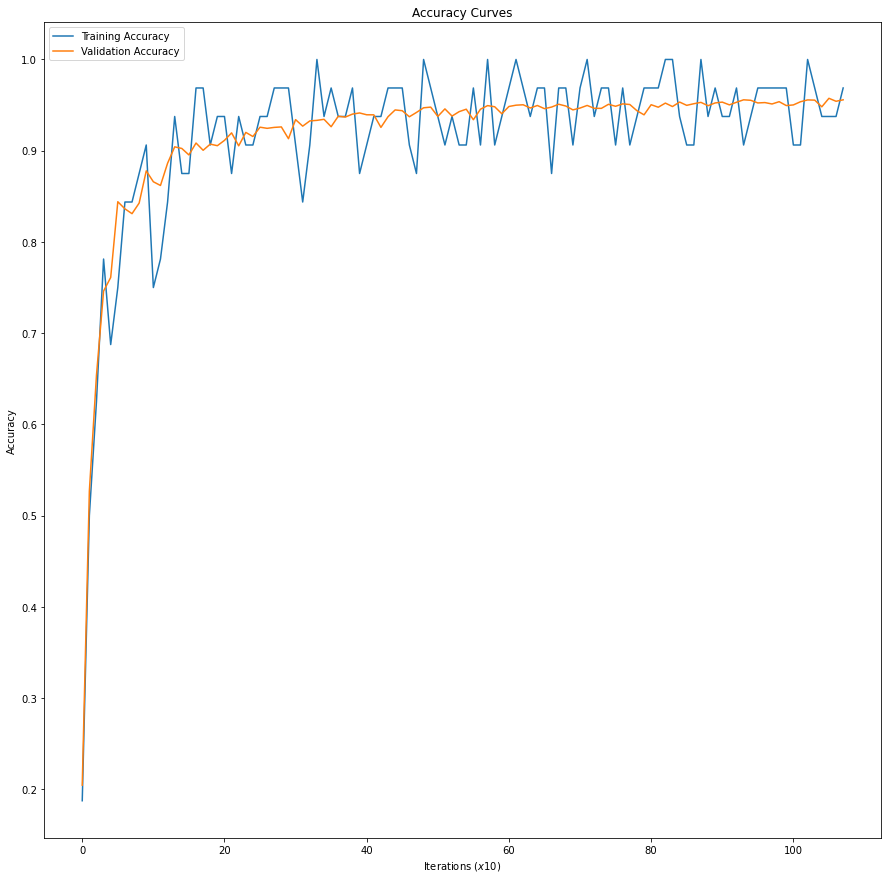

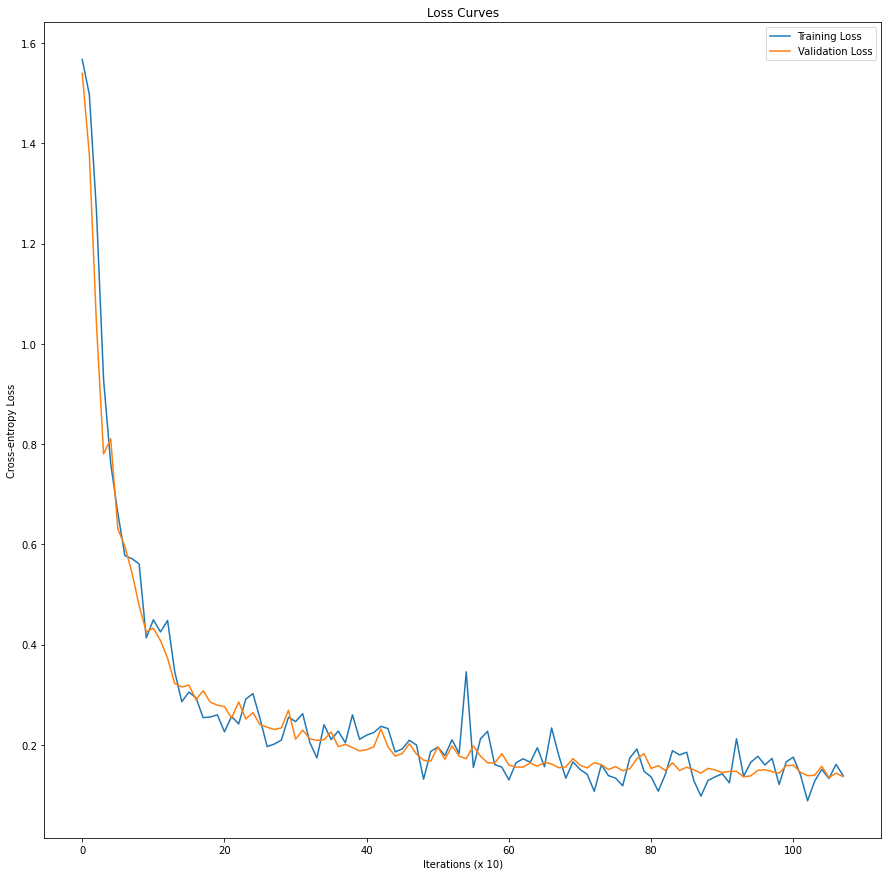

In [16]:
#accuracy curves
fig = plt.figure(figsize=(15,15))
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel("Iterations ($ x 10$)")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curves")
plt.show()

#loss curves
fig = plt.figure(figsize=(15,15))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel("Iterations (x 10)")
plt.ylabel("Cross-entropy Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

## Testing Results

Once the model has been trained and validated until it has satisfactory results, it needs to be tested on previously unseen data to ensure that it is able to perform under these conditions. In order to analyse these results, a confusion matrix will be employed. Here, the test data is simply loaded and put through the model, with the predicted outputs obtained. The results are then plotted in the confusion matrix. This shows that each shape is able to obtain an accuracy of at least 94%, with very little confusion between specific pairs of shapes. 

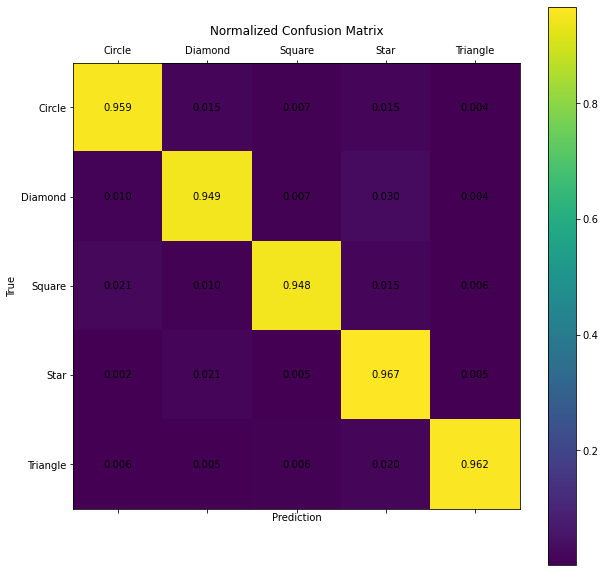

In [17]:
from sklearn.metrics import confusion_matrix
it = iter(test_loader) 

x, y = next(it)

outputs = model(x)
_, y_pred = torch.max(outputs, 1)

np.set_printoptions(precision=4)
plt.figure(figsize = (10,10))
cm = confusion_matrix(y.numpy(), y_pred.numpy(), normalize="true")
plt.matshow(cm, fignum=1)

for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')
    
plt.xticks(range(5))
plt.yticks(range(5))
plt.xlabel("Prediction")
plt.ylabel("True")

# We can retrieve the categories used by the LabelEncoder
classes=['Circle', 'Diamond', 'Square', 'Star', 'Triangle']
plt.gca().set_xticklabels(classes)
plt.gca().set_yticklabels(classes)

plt.title("Normalized Confusion Matrix")
plt.colorbar()
plt.show()

## Incorrect predictions

Some incorrect predictions are shown here to demonstrate possible reasons for incorrect predictions.

Because the dataset that is used is open source and contributed to by hundreds of thousands of users of Quickdraw, with very little moderation, there are images in each dataset that does not belong there. This causes images to be labelled as something that they aren't, and perhaps does not even fit into any of the classes. In the case of the latter, it only carries a 1/5 chance of being classified into the class it is labelled, which essentially defeats the putpose of the model.

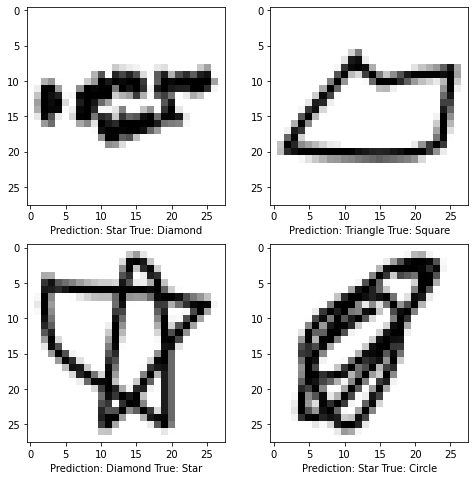

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()
# Get the indices for the cases where the predicted output was incorrect
false_idx = np.where(y.numpy() != y_pred.numpy())

for i, j in enumerate(false_idx[0][:4], 0):
    output = model(x[j].reshape(1, 1, 28, 28))
    _, y_pred = torch.max(output, 1)
    axes[i].imshow(x[j].reshape(28, 28), cmap='gray_r', interpolation='nearest')
    axes[i].set_xlabel("Prediction: {} True: {}".format(classes[y_pred.item()], classes[y[j]]))

plt.show() 

## Expansion to 8 Classes

The task was expanded to include 8 classes to determine if the network architecture remained suitable and was able to train a model for 8 classes. The classes were chosen to include simple shapes as well as more complicated objects such as flowers and ice cream. The classes with example images are shown below
<img src = '8class1.jpeg' width = 400>
<img src = '8class2.jpeg' width = 400> 
### Results

The model was trained and validated with 10 epochs, in a similar manner as the 5 classes above, and showed the following results for the validation and loss curves. The accuracy of the model settles to around (95%) which is adequate performance. However, we can see that the performance does not increase after the third epoch and such the model be trained until the third epoch to reduce time and resource requirements of training. Another benefit in reducing the epochs can be understood by looking at the loss curves. It is quite clear from the departure of the curves around 3 epochs that the model has started overfitting. While this overfitting is quite small (due to the nature of the Cross-Entropy Loss), it is an easily avoidable problem and is further proof that the model performance will not improve with increased training.

<img src = '8accuracy_curve.jpeg' width = 600>
<img src = '8loss_curve.jpeg' width = 600>

***

We can also look at the confusion matrix to analyse the test results of the model. These are consistently good returns with all classification above 91%. THe main confusion, and the only one more than 2.5% is the flower being classified as ice cream.

<img src = '8cm.jpeg' width = 700>

***

Reducing the epochs to 3 gives us similar results. It does seem, however, that the model performs more consistently across the dataset for each class with the minimum accuracy for a class being 93.3%, up from 91.8% when the model was trained by 10 epochs. However, the main take away here is that there is no degradation in model performance observed by reducing the epochs.

<img src = '8cm3.jpeg' width = 700>

***

Below we can see some examples of the confusions that occured when the model trained with 10 epochs. Two examples of a flower being classified as ice cream are shown, with the structure of the flower with the its stalk and leaf similar to that of a cone with ice cream. The first and last misclassifications once again point at the difficulty of working with an open - source dataset, as neither of those images vaguely resemble the 'true' label given to them. 
<img src = '8ip.jpeg' width = 700> 



## GUI Implementation

The GUI is implemented in a separate notebook named `GUIs.ipynb`. The GUI allows the user to either input an image, or use a drawing canvas to draw a shape or object. This image is then converted to a `.npy` array, resized, reshaped and prepared in the same manner as the test data was prepared, with the end product being a dataloader. The dataloader is used to load the image and put it through the model (accessed through the saved path), which provides a prediction, which is then displayed on the GUI.

This was a largely successful implementation. However, a challenge arose in obtaining the image from the drawing canvas resulting in varying results. Examples of the GUI running is shown below

A few test images are included in order to test the GUI implementation. (The `opencv` library is required for this)

<img src = 'gui1.png' width = 500>
<img src = 'gui2.png' width = 700>

## Conclusion

The project has been proven to be a success with results exceeding the 95% accuracy target that was set. This was achieved initially with an implementation with 5 shapes and then later with 8 objects, which included more complicated structures such as fish and ice cream. The implementation of Lenet- 5 Convolutional Neural Network Architecture was shown to be a success. The efficiency and speed of the Adam optimiser was also seen as only a 1 or 2 epochs were required to train the data with 5 classes, with 3 epochs required to train with 8 classes.

This project highlighted the importance of good data preparation as multiples steps, such as labelling, reshaping, splitting and transforming required to have the data in a form that is useful for the model. Failure to do so can result in varied results as seen in the GUI implementation of the drawing canvas.

The importance of having an accurate and correctly labelled dataset was also seen as the open-source Quickdraw dataset contained some incorrect images which were incorrectly classified when tested and likely when validated as well.

